# Test different interpolations

In [91]:
import numpy as np
import scipy.special as special
import scipy.integrate as integrate
import matplotlib.pyplot as plt
# fake beta function
def special_beta(alpha, beta): return special.gamma(alpha)*special.gamma(beta)/special.gamma(alpha+beta)

In [92]:
def get_toy_pdf_x(alpha, beta):
    """test fnc in x"""
    return lambda x,alpha=alpha,beta=beta: x**alpha * (1-x)**beta
def get_toy_pdf_N(alpha, beta):
    return lambda N: special_beta(N+alpha,beta+1)

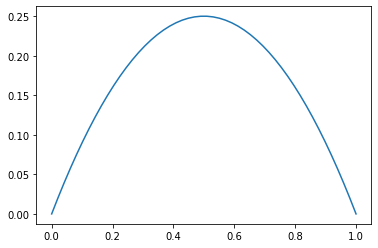

In [93]:
xs = np.linspace(0,1)
ys = get_toy_pdf_x(1,1)(xs)
plt.plot(xs,ys)
plt.show()

In [94]:
def get_linear_iterpolators_x(x,xgrid,j):
    """get j-th linear interpolator of grid"""
    l = len(xgrid)
    if l < 2 : raise "need at least 2 points"
    if 0 == j: return (xgrid[1]-x)/(xgrid[1]) if x <= xgrid[1] else 0.
    if l - 1 == j: return (x-xgrid[-2])/(xgrid[-1] - xgrid[-2]) if x >= xgrid[-2] else 0.
    if (xgrid[j]-x)*(x-xgrid[j-1]) > 0:
        return (x-xgrid[j-1])/(xgrid[j]-xgrid[j-1])
    if (xgrid[j]-x)*(x-xgrid[j+1]) >= 0:
        return (xgrid[j+1]-x)/(xgrid[j+1]-xgrid[j])
    return 0.

In [95]:
def get_Lagrange_iterpolators_x(x,xgrid,j):
    """get j-th Lagrange interpolator of grid in x"""
    l = len(xgrid)
    if l < 2 : raise "need at least 2 points"
    d = np.prod([1 if j == k else xgrid[j] - xgrid[k] for k in range(l)])
    n = np.prod([1 if j == k else x - xgrid[k] for k in range(l)])
    return n/d
def get_Lagrange_iterpolators_N(N,xgrid,j):
    """get j-th Lagrange interpolator of grid in N"""
    l = len(xgrid)
    if l < 2 : raise "need at least 2 points"
    d = np.prod([1 if j == k else xgrid[j] - xgrid[k] for k in range(l)])
    from numpy.polynomial import Polynomial as P
    nx = np.prod([P([1]) if j == k else P([- xgrid[k],1]) for k in range(l)])
    n = np.sum([nx.coef[k]*special_beta(N+k,1) for k in range(l)])
    return n/d

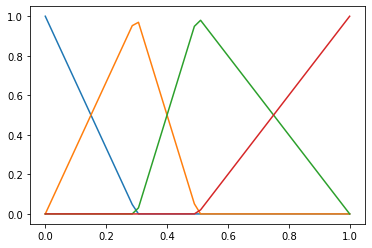

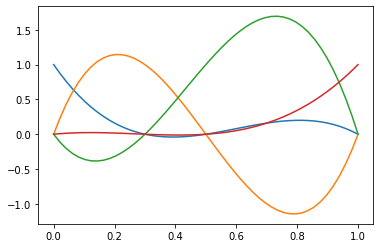

In [106]:
def plot_iterpolators_x(f,g):
    """plot all linear interpolators of grid"""
    xs = np.linspace(0,1)
    for j in range(len(g)):
        ys = [f(x,g,j) for x in xs]
        plt.plot(xs,ys)
    plt.show()

plot_iterpolators_x(get_linear_iterpolators_x,[0.,.3,.5,1.])
plot_iterpolators_x(get_Lagrange_iterpolators_x,[0.,.3,.5,1.])

/home/felix/Physik/N3PDF/EKO/eko/env/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


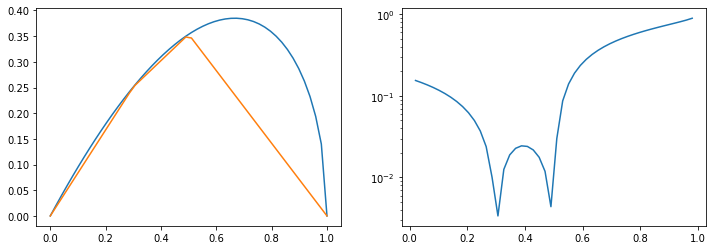

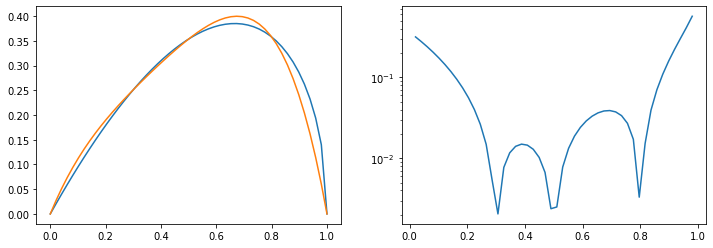

In [107]:
def test_iterpolation_x(f,p,g):
    """plots interpolation vs real thing in x"""
    fs = [f(x) for x in g]
    fp = lambda y,g=g,fs=fs: np.sum([fs[j]*p(y,g,j) for j in range(len(g))])
    xs = np.linspace(0,1)
    ys = [f(x) for x in xs]
    plt.figure(1,(12,4))
    plt.subplot(121)
    plt.plot(xs,ys)
    yps = [fp(x) for x in xs]
    plt.plot(xs,yps)
    plt.subplot(122)
    plt.semilogy(xs,[np.abs((ys[j] - yps[j])/ys[j]) for j in range(len(xs))])
    plt.show()

test_iterpolation_x(get_toy_pdf_x(1,.5),get_linear_iterpolators_x,[0.,.3,.5,1.])
test_iterpolation_x(get_toy_pdf_x(1,.5),get_Lagrange_iterpolators_x,[0.,.3,.5,.8,1.])

In [98]:
def Mellin_trafo(f,N):
    """straight implementation of the Mellin transform"""
    r,re = integrate.quad(lambda x,f=f,N=N: np.real(x**(N-1)*f(x)),0,1)
    i,ie = integrate.quad(lambda x,f=f,N=N: np.imag(x**(N-1)*f(x)),0,1)
    return np.complex(r,i),np.complex(re,ie)

In [102]:
toy_alpha = 2.3
toy_beta = .5
for c in [np.complex(2,2),np.complex(2,-2),np.complex(-1,2)]:
    e = get_toy_pdf_N(toy_alpha,toy_beta)(c)
    i,ie = Mellin_trafo(get_toy_pdf_x(toy_alpha,toy_beta),c)
    print("exact = ",e,", int = ",i,", |rel_err| = ",np.abs((e-i)/e))

exact =  (0.06506938494905695-0.046801971951956206j) , int =  (0.0650693849441131-0.04680197194966553j) , |rel_err| =  6.797962151083868e-11
exact =  (0.06506938494905695+0.046801971951956206j) , int =  (0.0650693849441131+0.04680197194966553j) , |rel_err| =  6.797962151083868e-11
exact =  (0.041834527464115055-0.21549284638271926j) , int =  (0.041834527409332224-0.21549284630671234j) , |rel_err| =  4.268121107916933e-10


In [103]:
g = [0.,.5,1.]
for k in range(len(g)):
    for c in [np.complex(2,2),np.complex(2,-2),np.complex(-1,2)]:
        e = get_Lagrange_iterpolators_N(c,g,k)
        i,ie = Mellin_trafo(lambda x: get_Lagrange_iterpolators_x(x,g,k),c)
        print("exact = ",e,", int = ",i,", |rel_err| = ",np.abs((e-i)/e))

exact =  (-0.042307692307692824+0.011538461538461775j) , int =  (-0.042307691866726164+0.011538461538452381j) , |rel_err| =  1.0055586960358765e-08
exact =  (-0.042307692307692824-0.011538461538461775j) , int =  (-0.042307691866726164-0.011538461538452381j) , |rel_err| =  1.0055586960358765e-08
exact =  (0.2000000000000001+0.2999999999999977j) , int =  (0.19999999975547797+0.29999999959768586j) , |rel_err| =  1.3057443929252638e-09
exact =  (0.1230769230769232-0.21538461538461523j) , int =  (0.12307692307791729-0.2153846153792987j) , |rel_err| =  2.180302686296589e-11
exact =  (0.1230769230769232+0.21538461538461523j) , int =  (0.12307692307791729+0.2153846153792987j) , |rel_err| =  2.180302686296589e-11
exact =  (-0.7999999999999999-0.3999999999999968j) , int =  (-0.8000000000000056-0.3999999999999926j) , |rel_err| =  7.894497640785713e-15
exact =  (0.16923076923076927-0.04615384615384624j) , int =  (0.16923076924086644-0.04615384615517567j) , |rel_err| =  5.8059532806480326e-11
exact

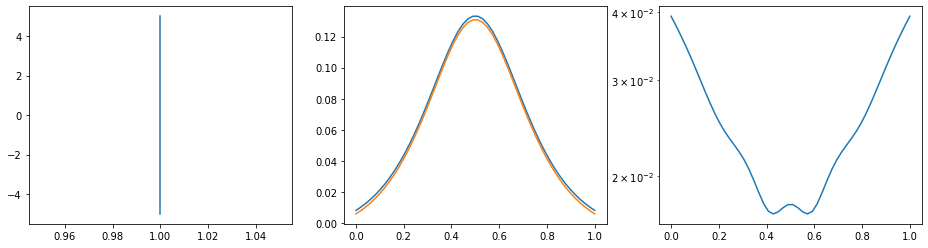

In [104]:
def test_iterpolation_N(fx,fN,pN,g,path):
    """plots interpolation to real thing in x"""
    fxs = [fx(x) for x in g]
    fNp = lambda N,g=g,fxs=fxs: np.sum([fxs[j]*pN(N,g,j) for j in range(len(g))])
    ts = np.linspace(0,1)
    plt.figure(1,(16,4))
    plt.subplot(131)
    ys = [path(t) for t in ts]
    plt.plot(np.real(ys),np.imag(ys))
    ys = [fN(path(t)) for t in ts]
    plt.subplot(132)
    plt.plot(ts,ys)
    yps = [fNp(path(t)) for t in ts]
    plt.plot(ts,yps)
    plt.subplot(133)
    plt.semilogy(ts,[np.abs((ys[j] - yps[j])/ys[j]) for j in range(len(xs))])
    plt.show()

toy_alpha = 2.3
toy_beta = .5
test_iterpolation_N(get_toy_pdf_x(toy_alpha,toy_beta),get_toy_pdf_N(toy_alpha,toy_beta),get_Lagrange_iterpolators_N,np.linspace(0,1,num=10),lambda t : np.complex(1,5*(2*t-1)))